# An extensive Time Series tutorial

### Import libraries to work with

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.linear_model import LassoLarsCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, learning_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM2D, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, TimeDistributed, Input
from keras.layers.merge import concatenate
from keras.utils import plot_model

### Load the data

In [3]:
input_data = pd.read_csv('inputs.csv',header=None)
output_data = pd.read_csv('outputs.csv',header=None)

In [4]:
input_data.shape

(1000, 3)

In [5]:
input_data.head()

,0,1,2
0,1253.688798,43.459183,-0.081048
1,1253.658489,1.849287,-0.104586
2,1253.682101,-88.224989,-0.110097
3,1253.691660,-81.198326,-0.143408
4,1253.638780,-122.391441,-0.168541


In [6]:
output_data.shape

(1000, 1)

In [7]:
output_data.head()

,0
0,-0.662891
1,-0.006388
2,-0.613494
3,-0.664729
4,0.175758


### Check for unexpected (missing, infinite etc.) values

In [8]:
np.isnan(input_data.iloc[:,0]).any()

False

In [9]:
np.isnan(input_data.iloc[:,1]).any()

False

In [10]:
np.isnan(input_data.iloc[:,2]).any()

False

In [11]:
np.isfinite(input_data.iloc[:,0]).all()

True

In [12]:
np.isfinite(input_data.iloc[:,1]).all()

True

In [13]:
np.isfinite(input_data.iloc[:,2]).all()

True

## Two-stage Stationarity check process

It is time to check whether the data are stationary or not in order to move on properly. We are going to use two statistical tests to evaluate the stationarity of our data given that our null hypothesis in both cases (which we try to reject) is that the time series are non-stationary: i) Augmented Dickey-Fuller test ii) KPSS test

We are going to evaluate each variable separately to stationarise it, if necessary. This is due to the multivariate time-series we have got.

**NOTE!:** It’s always better to apply both the tests, so that we are sure that the series is truly stationary. Let us look at the possible outcomes of applying these stationary tests.

***Case 1:*** Both tests conclude that the series is not stationary -> series is not stationary

***Case 2:*** Both tests conclude that the series is stationary -> series is stationary

***Case 3:*** KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary

***Case 4:*** KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

In [34]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    roll_mean = timeseries.rolling(12).mean()
    roll_std = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    ### Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    
    # The number of lags is chosen to minimise the Akaike's Information Criterion (AIC)
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    print('\n\n')
    
    ### Perform KPSS test:
    print ('Results of KPSS Test:')
    
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

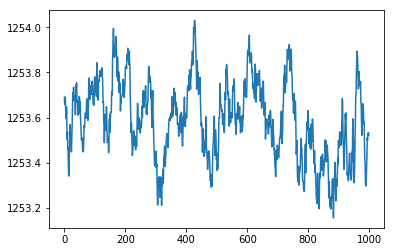

In [35]:
plt.plot(input_data.iloc[:,0])

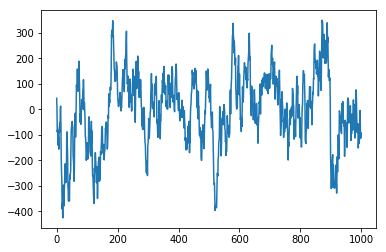

In [36]:
plt.plot(input_data.iloc[:,1])

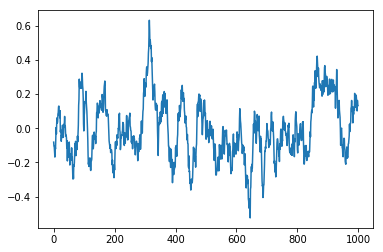

In [37]:
plt.plot(input_data.iloc[:,2])

**Note!:** At this point empirically we can say that the Time-Series are in a stationary format. However, it goes without saying that we will verify this empirical assumption made at a first glance by statistical methods.

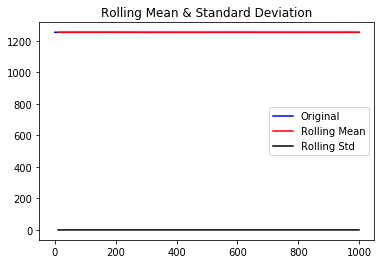

Results of Dickey-Fuller Test:
Test Statistic                  -4.718431
p-value                          0.000078
#Lags Used                       1.000000
Number of Observations Used    998.000000
Critical Value (1%)             -3.436919
Critical Value (5%)             -2.864440
Critical Value (10%)            -2.568314
dtype: float64



Results of KPSS Test:
Test Statistic            0.742531
p-value                   0.010000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1276: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [38]:
test_stationarity(input_data.iloc[:,0])

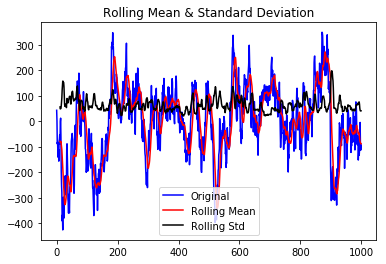

Results of Dickey-Fuller Test:
Test Statistic                  -5.135536
p-value                          0.000012
#Lags Used                      22.000000
Number of Observations Used    977.000000
Critical Value (1%)             -3.437061
Critical Value (5%)             -2.864503
Critical Value (10%)            -2.568348
dtype: float64



Results of KPSS Test:
Test Statistic            0.360232
p-value                   0.094297
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [39]:
test_stationarity(input_data.iloc[:,1])

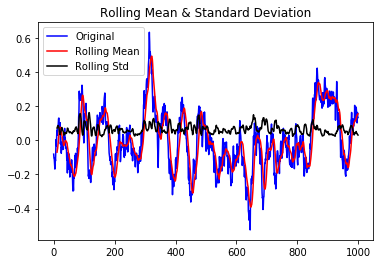

Results of Dickey-Fuller Test:
Test Statistic                  -5.482015
p-value                          0.000002
#Lags Used                      13.000000
Number of Observations Used    986.000000
Critical Value (1%)             -3.436999
Critical Value (5%)             -2.864476
Critical Value (10%)            -2.568333
dtype: float64



Results of KPSS Test:
Test Statistic            0.213035
p-value                   0.100000
Lags Used                22.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1278: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [40]:
test_stationarity(input_data.iloc[:,2])

**Corollary:** According to the statistic tests we implemented, we can say that we strongly reject our null hypothesis - due to the very small p-values - which means that our Time-Series are stationary. That being said, we can move onto the next stage of our process to develop the predictive regression model.

### Hypothetical case (Non-stationary data)

If the Time-Series were non-stationary, then we would follow the following process to bring them into the proper format:

*i) We would apply a transformation (e.g. logarithmic transformation) to the Time-Series to reduce trend.*

*ii) In case the Time-Series were also sufficiently noisy, we would need to estimate and model the trend by smoothing for example (or by aggregating or polynomial fitting). Indicatively, we could work with an exponentially weighted moving average (or other kind of moving average).*

*iii) If the situation had not been resolved yet, then we could have used differencing (of first order, for instance) or decomposing (e.g. seasonal decomposition) to eliminate trend and seasonality which Time-Series more often than not suffer from.*

After those steps, we would eventually have ended up with fine Time-Series to work with.

### Data manipulation

In [21]:
X = input_data.values
y = output_data.values

In [22]:
X = StandardScaler().fit_transform(X)

In [23]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

kf = TimeSeriesSplit(n_splits=4) 
kf.get_n_splits(X)

4

In [24]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


## Lasso regression model

The first model I developed is a Cross-Validated (for the alpha parameter) Lasso model using the Least Angle Regression (LARS) to benefit from more accurate exploration for the alpha parameter.

Fold: # 1


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


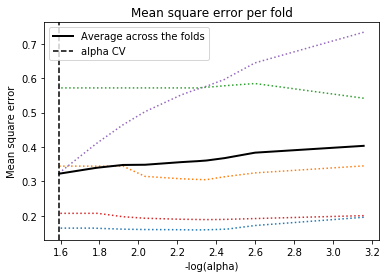

Fold: # 2


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


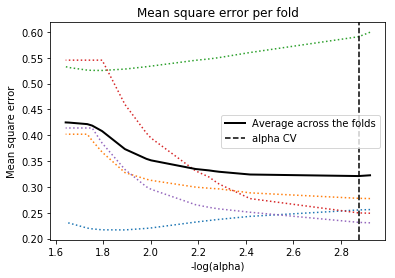

Fold: # 3


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


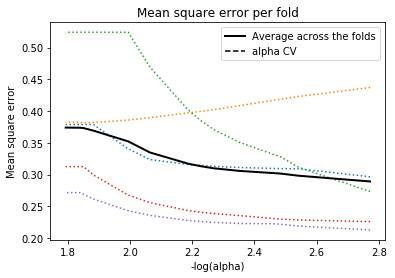

Fold: # 4


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


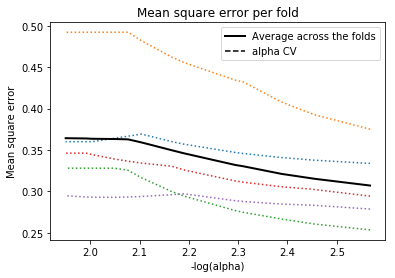

In [24]:
lasso_r2_scores = []
lasso_mse_scores = []

i = 0

for train_index, test_index in kf.split(X,y):
    print('Fold: #',i+1)
        
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Lasso training
    lasso_model = LassoLarsCV(cv=5).fit(X_train, np.ravel(y_train))
    
    # Lasso scores
    lasso_r2_scores.append(lasso_model.score(X_test, np.ravel(y_test)))
    lasso_mse_scores.append(mean_squared_error(np.ravel(y_test),lasso_model.predict(X_test)))
    
    # Lasso results
    m_log_alphas = -np.log10(lasso_model.cv_alphas_)

    plt.figure()
    plt.plot(m_log_alphas, lasso_model.mse_path_, ':')
    plt.plot(m_log_alphas, lasso_model.mse_path_.mean(axis=-1), 'k',
             label='Average across the folds', linewidth=2)
    plt.axvline(-np.log10(lasso_model.alpha_), linestyle='--', color='k',
                label='alpha CV')
    plt.legend()

    plt.xlabel('-log(alpha)')
    plt.ylabel('Mean square error')
    plt.title('Mean square error per fold')
    plt.axis('tight')

    plt.show()
    
    i += 1

In [25]:
print('Average R2 score of Lasso-LARS model is: ', np.mean(lasso_r2_scores))
print('Average MSE of Lasso-LARS model is: ', np.mean(lasso_mse_scores))

Average R2 score of Lasso-LARS model is:  0.09081661352351367
Average MSE of Lasso-LARS model is:  0.34063690566530297


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

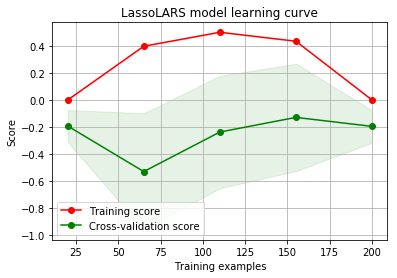

In [26]:
plot_learning_curve(LassoLarsCV(cv=5), 'LassoLARS model learning curve', X, np.ravel(y), cv=TimeSeriesSplit(n_splits=4))

## Support Vector Machine regression model

The second attempt will be done by using a SVR model with Gaussian kernels to cope with the higher dimensionality of our case.

In [27]:
svr_r2_scores = []
svr_mse_scores = []

i = 0

for train_index, test_index in kf.split(X,y):
    print('Fold: #',i+1)
        
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    svr_estimator = SVR(C=10.0, gamma='auto')

    # SVM training
    svr_model = svr_estimator.fit(X_train, np.ravel(y_train))
    
    # SVM scores
    svr_r2_scores.append(svr_model.score(X_test, np.ravel(y_test)))
    svr_mse_scores.append(mean_squared_error(np.ravel(y_test),svr_model.predict(X_test)))
    
    i += 1

Fold: # 1
Fold: # 2
Fold: # 3
Fold: # 4


In [28]:
print('Average R2 score of SVR model is: ', np.mean(svr_r2_scores))
print('Average MSE of SVR model is: ', np.mean(svr_mse_scores))

Average R2 score of SVR model is:  0.4600741780257596
Average MSE of SVR model is:  0.22149670023499557


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

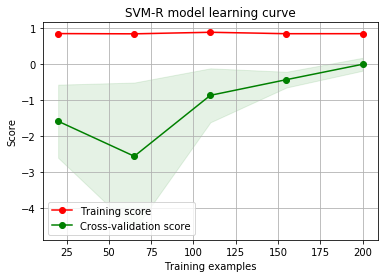

In [29]:
plot_learning_curve(SVR(C=10.0, gamma='auto'), 'SVM-R model learning curve', X, np.ravel(y), cv=TimeSeriesSplit(n_splits=4))

## Gradient Boosting with regression trees regression model

Fold: # 1
Fold: # 2
Fold: # 3
Fold: # 4


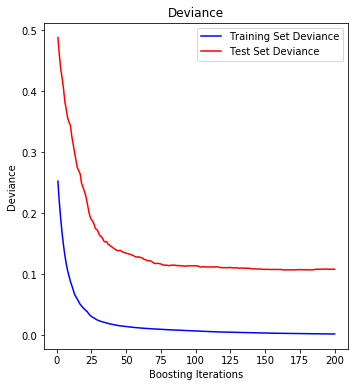

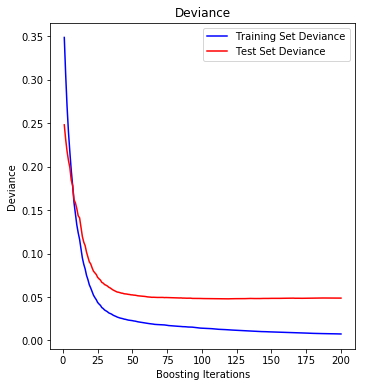

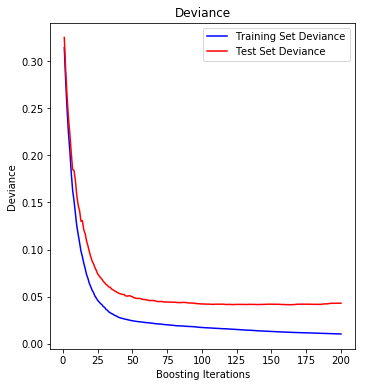

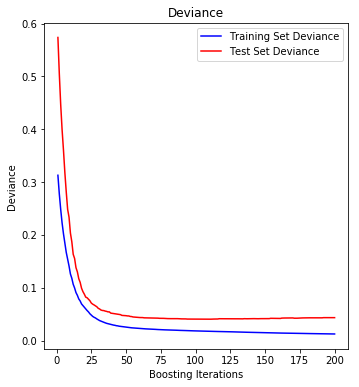

In [30]:
grad_boost_r2_scores = []
grad_boost_mse_scores = []

k = 0

for train_index, test_index in kf.split(X,y):
    print('Fold: #',k+1)
        
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    grad_boost_estimator = GradientBoostingRegressor(n_estimators=200,
                                          criterion='friedman_mse',
                                          max_depth=3,
                                          verbose=0)

    # Gradient Boosting training
    grad_boost_model = grad_boost_estimator.fit(X_train, np.ravel(y_train))
    
    # Gradient Boosting scores
    grad_boost_r2_scores.append(grad_boost_model.score(X_test, np.ravel(y_test)))
    grad_boost_mse_scores.append(mean_squared_error(np.ravel(y_test),grad_boost_model.predict(X_test)))
    
    # Plot training deviance

    # Compute test set deviance
    test_score = np.zeros((200,), dtype=np.float32)

    for i, y_pred in enumerate(grad_boost_estimator.staged_predict(X_test)):
        test_score[i] = grad_boost_estimator.loss_(np.ravel(y_test), y_pred)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Deviance')
    plt.plot(np.arange(200) + 1, grad_boost_estimator.train_score_, 'b-',
             label='Training Set Deviance')
    plt.plot(np.arange(200) + 1, test_score, 'r-',
             label='Test Set Deviance')
    plt.legend(loc='upper right')
    plt.xlabel('Boosting Iterations')
    plt.ylabel('Deviance')
    
    k += 1

In [31]:
print('Average R2 score of Gradient Boosting model is: ', np.mean(grad_boost_r2_scores))
print('Average MSE of Gradient Boosting model is: ', np.mean(grad_boost_mse_scores))

Average R2 score of Gradient Boosting model is:  0.8392565139864816
Average MSE of Gradient Boosting model is:  0.060926036302897446


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/pyplot.py'>

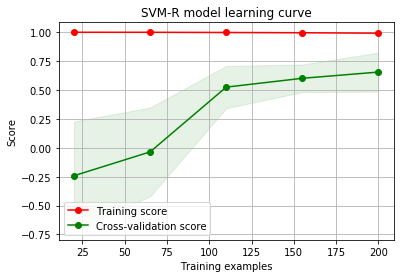

In [32]:
plot_learning_curve(GradientBoostingRegressor(n_estimators=200,
                                              criterion='friedman_mse',
                                              max_depth=3,
                                              verbose=0), 
                    'SVM-R model learning curve', X, np.ravel(y), cv=TimeSeriesSplit(n_splits=4))

## Multi-Layer Perceptron (Deep Neural Network architecture)

### Further Data Preprocessing

At this point, we will not use TimeSeriesSplit anymore. Instead, we will split training and test sets explicitly. At the same time, instead of using one-step models, we will use a larger look-back model and thus, a different preprocessing is required.

A rather simple DNN will be developed below consissting of fully connected layers and dropout layers. Although for this dataset, the use of Dropout layers may be an overkill, this model architecture has been mainly designed for demonstration purposes and not for achieving the optimal performance. Besides, we have not gone so far and will not go below for a Hyperparameter optimisation.

In [25]:
y = np.ravel(y)
feat1 = X[:,0]
feat2 = X[:,1]
feat3 = X[:,2]

In [26]:
def look_back_split(data, look_back=1):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back), 0])
        y.append(data[i+look_back, 0])
    return np.array(X), np.array(y)

In [27]:
thres = int(len(X)*0.8)

feat1_train = feat1[:thres]
feat2_train = feat2[:thres]
feat3_train = feat3[:thres]

feat1_test = feat1[thres:]
feat2_test = feat2[thres:]
feat3_test = feat3[thres:]

y_train = y[:thres]
y_test = y[thres:]

look_back = 3

In [28]:
training_data = np.transpose(np.vstack((feat1_train, feat2_train, feat3_train, y_train))).astype('float32')
test_data = np.transpose(np.vstack((feat1_test, feat2_test, feat3_test, y_test))).astype('float32')

In [29]:
training_data.shape

(800, 4)

In [30]:
training_data[:5,:]

array([[ 0.5868008 ,  0.33570996, -0.43111488, -0.66289055],
       [ 0.40764806,  0.04296986, -0.5691684 , -0.00638751],
       [ 0.54721594, -0.590734  , -0.6014877 , -0.61349446],
       [ 0.6037219 , -0.541299  , -0.796855  , -0.66472924],
       [ 0.2911519 , -0.83110684, -0.94426113,  0.1757584 ]],
      dtype=float32)

In [31]:
test_data.shape

(200, 4)

In [32]:
test_data[:5,:]

array([[ 0.09436803, -0.75929904, -0.68595415,  0.49918887],
       [-0.07794347, -0.61809075, -0.80173886,  0.499162  ],
       [-0.6180166 , -0.72220564, -0.3568552 , -0.11898148],
       [-0.44627222, -1.0118898 , -0.14686243,  0.24191034],
       [-0.48515528, -0.99061626, -0.22773784,  0.07555294]],
      dtype=float32)

In [33]:
X_train, y_train = look_back_split(training_data,3)
X_test, y_test = look_back_split(test_data,3)

In [35]:
X_train[:5,:]

array([[0.5868008 , 0.40764806, 0.54721594],
       [0.40764806, 0.54721594, 0.6037219 ],
       [0.54721594, 0.6037219 , 0.2911519 ],
       [0.6037219 , 0.2911519 , 0.18776992],
       [0.2911519 , 0.18776992, 0.02929852]], dtype=float32)

In [37]:
y_train[:5]

array([0.6037219 , 0.2911519 , 0.18776992, 0.02929852, 0.3369556 ],
      dtype=float32)

### Model design

In [42]:
mlp_model = Sequential()
mlp_model.add(Dense(128, input_dim=look_back, activation='relu'))
mlp_model.add(Dropout(0.25))
mlp_model.add(Dense(8, activation='relu'))
mlp_model.add(Dense(1))

In [43]:
mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 1,553
Trainable params: 1,553
Non-trainable params: 0
_________________________________________________________________


In [44]:
mlp_model.compile(loss='mean_squared_error', optimizer='adam')

### Model training

In [45]:
history = mlp_model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, validation_data=(X_test, y_test))

Train on 796 samples, validate on 196 samples
Epoch 1/100
796/796 [==============================] - 0s 405us/step - loss: 0.2621 - val_loss: 0.1445
Epoch 2/100
796/796 [==============================] - 0s 139us/step - loss: 0.1098 - val_loss: 0.1196
Epoch 3/100
796/796 [==============================] - 0s 136us/step - loss: 0.0996 - val_loss: 0.1093
Epoch 4/100
796/796 [==============================] - 0s 138us/step - loss: 0.0934 - val_loss: 0.0999
Epoch 5/100
796/796 [==============================] - 0s 138us/step - loss: 0.0879 - val_loss: 0.0992
Epoch 6/100
796/796 [==============================] - 0s 138us/step - loss: 0.0924 - val_loss: 0.0948
Epoch 7/100
796/796 [==============================] - 0s 138us/step - loss: 0.0861 - val_loss: 0.1062
Epoch 8/100
796/796 [==============================] - 0s 136us/step - loss: 0.0820 - val_loss: 0.0978
Epoch 9/100
796/796 [==============================] - 0s 141us/step - loss: 0.0839 - val_loss: 0.0933
Epoch 10/100
796/796 [=====

### Model evaluation

In [46]:
score = mlp_model.evaluate(X_test, y_test, verbose=1)

196/196 [==============================] - 0s 27us/step


In [47]:
print('The MSE on the test set is: ', score)

The MSE on the test set is:  0.10604691288757082


### Plot results

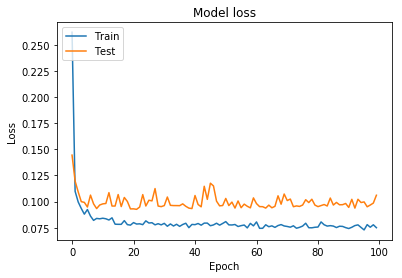

In [48]:
# Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Multi-stream ConvLSTM regression model

Below we will design a DNN consisting of Convolutional, Pooling, LSTM, Dropout and fully connected layers. It will be a multi-stream architecture. More specifically, we assume that the data are of different frequency and hence,  we need to process them separately into separate streams.

I remind that I opted for this architecture only for demonstrating a different more sophisticated architecture which is flexible and effective for many similar problems.

### Data preprocessing

Again, we need to design an different data engineering process due to the different approach we are going to design. Now, we are going to handle mixed kinds of sequences; uni- and multi-variate sequences per steps. Thus, we will need to split all those sequences before feeding our data into our model

In [49]:
# univariate_seq = X[:,0]
# multivariate_seq = X[:,1:]
# y = np.ravel(y) # run this command unless the MLP above has not been executed
# thres = int(len(X)*0.8)
# X_train_uni = univariate_seq[:thres]
# X_test_uni = univariate_seq[thres:]
# X_train_multi = multivariate_seq[:thres,:]
# X_test_multi = multivariate_seq[thres:,:]
# y_train = y[:thres]
# y_test = y[thres:]

In [38]:
def split_multivariate_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix, :-1], sequence[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [39]:
# y = np.ravel(y) # run this command unless the MLP above has not been executed
feat1 = X[:,0]
feat2 = X[:,1]
feat3 = X[:,2]

In [40]:
thres = int(len(X)*0.8)

feat1_train = feat1[:thres]
feat2_train = feat2[:thres]
feat3_train = feat3[:thres]

feat1_test = feat1[thres:]
feat2_test = feat2[thres:]
feat3_test = feat3[thres:]

y_train = y[:thres]
y_test = y[thres:]

In [41]:
stream1_train = np.transpose(np.vstack((feat2_train, y_train))).astype('float32')
stream2_train = np.transpose(np.vstack((feat3_train, y_train))).astype('float32')
stream1_test = np.transpose(np.vstack((feat2_test, y_test))).astype('float32')
stream2_test = np.transpose(np.vstack((feat3_test, y_test))).astype('float32')

In [42]:
n_steps = 2
X_train_stream1, y_train_stream1 = split_multivariate_sequence(stream1_train, n_steps)
X_train_stream2, y_train_stream2 = split_multivariate_sequence(stream2_train, n_steps)
X_test_stream1, y_test_stream1 = split_multivariate_sequence(stream1_test, n_steps)
X_test_stream2, y_test_stream2 = split_multivariate_sequence(stream2_test, n_steps)

In [43]:
# X_train_stream1 = feat1_train
# X_test_stream1 = feat1_test

In [44]:
X_train_stream1.shape

(799, 2, 1)

In [45]:
X_train_stream2.shape

(799, 2, 1)

In [46]:
n_features = 1
n_seq = 1
n_steps = 2

# For ConvLSTM2D use this reshape
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
# X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
X_train_stream1 = X_train_stream1.reshape((X_train_stream1.shape[0], n_seq, 1, n_steps, n_features))
X_train_stream2 = X_train_stream2.reshape((X_train_stream2.shape[0], n_seq, 1, n_steps, n_features))
X_test_stream1 = X_test_stream1.reshape((X_test_stream1.shape[0], n_seq, 1, n_steps, n_features))
X_test_stream2 = X_test_stream2.reshape((X_test_stream2.shape[0], n_seq, 1, n_steps, n_features))

# For explicit use of CNN and LSTM use this reshape and move on as usual
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
# X_train_stream1 = X_train_stream1.reshape((X_train_stream1.shape[0], 2, 1, 1))
# X_train_stream2 = X_train_stream2.reshape((X_train_stream2.shape[0], 2, 2, 1))
# X_test_stream1 = X_test_stream1.reshape((X_test_stream1.shape[0], 2, 1, 1))
# X_test_stream2 = X_test_stream2.reshape((X_test_stream2.shape[0], 2, 2, 1))

In [47]:
X_train_stream1.shape

(799, 1, 1, 2, 1)

In [48]:
X_train_stream2.shape

(799, 1, 1, 2, 1)

In [49]:
assert y_train_stream1.all() == y_train_stream2.all(), 'Wrong splitting!'
y_train = y_train_stream1 # Or y_train_stream2 can be also assigned to y_train since they are the same vectors.

In [50]:
assert y_test_stream1.all() == y_test_stream2.all(), 'Wrong splitting!'
y_test = y_test_stream1 # Or y_test_stream2 can be also assigned to y_test since they are the same vectors.

In [51]:
y_train.shape

(799,)

In [52]:
X_train_stream1 = np.array(X_train_stream1)
X_train_stream2 = np.array(X_train_stream2)
X_test_stream1 = np.array(X_test_stream1)
X_test_stream2 = np.array(X_test_stream2)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [53]:
X_train_stream1.shape

(799, 1, 1, 2, 1)

In [54]:
X_train_stream2.shape

(799, 1, 1, 2, 1)

### Model design

In [55]:
# model = Sequential()
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 2, 1)))
# model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(50, activation='relu'))
# model.add(Dense(1))

In [70]:
# Stream 1
input1 = Input(shape=(None, 1, n_steps, n_features))
conv1 = ConvLSTM2D(32, kernel_size=(1,n_steps), activation='relu')(input1)
dropout11 = Dropout(0.25)(conv1)
flat1 = Flatten()(dropout11)
dense1 = Dense(64, activation='relu')(flat1)
dropout12 = Dropout(0.25)(dense1)

# Stream 2
input2 = Input(shape=(None, 1, n_steps, n_features))
conv2 = ConvLSTM2D(32, kernel_size=(1,n_steps), activation='relu')(input2)
dropout21 = Dropout(0.25)(conv2)
flat2 = Flatten()(dropout21)
dense2 = Dense(64, activation='relu')(flat2)
dropout22 = Dropout(0.25)(dense2)

# Interpolation
concat = concatenate([dropout12, dropout22])
dense = Dense(8, activation='relu')(concat)

# Output
final_dense = Dense(1)(dense)

conv_lstm_model = Model(inputs=[input1, input2], outputs=final_dense)

In [71]:
conv_lstm_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, None, 1, 2, 1 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, None, 1, 2, 1 0                                            
__________________________________________________________________________________________________
conv_lst_m2d_5 (ConvLSTM2D)     (None, 1, 1, 16)     2240        input_5[0][0]                    
__________________________________________________________________________________________________
conv_lst_m2d_6 (ConvLSTM2D)     (None, 1, 1, 16)     2240        input_6[0][0]                    
__________________________________________________________________________________________________
dropout_9 

In [72]:
conv_lstm_model.compile(optimizer='adam', loss='mse')

### Model training

In [73]:
multi_history = conv_lstm_model.fit([X_train_stream1, X_train_stream2], y_train, epochs=2000, batch_size=8, verbose=1, validation_data=([X_test_stream1, X_test_stream2], y_test))

Train on 799 samples, validate on 199 samples
Epoch 1/2000
799/799 [==============================] - 2s 3ms/step - loss: 0.3389 - val_loss: 0.5675
Epoch 2/2000
799/799 [==============================] - 0s 472us/step - loss: 0.2847 - val_loss: 0.3982
Epoch 3/2000
799/799 [==============================] - 0s 437us/step - loss: 0.2861 - val_loss: 0.3948
Epoch 4/2000
799/799 [==============================] - 0s 436us/step - loss: 0.2781 - val_loss: 0.3370
Epoch 5/2000
799/799 [==============================] - 0s 431us/step - loss: 0.2765 - val_loss: 0.3111
Epoch 6/2000
799/799 [==============================] - 0s 428us/step - loss: 0.2773 - val_loss: 0.3469
Epoch 7/2000
799/799 [==============================] - 0s 441us/step - loss: 0.2826 - val_loss: 0.3705
Epoch 8/2000
799/799 [==============================] - 0s 450us/step - loss: 0.2746 - val_loss: 0.3810
Epoch 9/2000
799/799 [==============================] - 0s 446us/step - loss: 0.2756 - val_loss: 0.3595
Epoch 10/2000
799/79

799/799 [==============================] - 0s 415us/step - loss: 0.2314 - val_loss: 0.3182
Epoch 156/2000
799/799 [==============================] - 0s 413us/step - loss: 0.2377 - val_loss: 0.2950
Epoch 157/2000
799/799 [==============================] - 0s 413us/step - loss: 0.2396 - val_loss: 0.3061
Epoch 158/2000
799/799 [==============================] - 0s 425us/step - loss: 0.2363 - val_loss: 0.3013
Epoch 159/2000
799/799 [==============================] - 0s 438us/step - loss: 0.2297 - val_loss: 0.3121
Epoch 160/2000
799/799 [==============================] - 0s 424us/step - loss: 0.2325 - val_loss: 0.3014
Epoch 161/2000
799/799 [==============================] - 0s 412us/step - loss: 0.2365 - val_loss: 0.2728
Epoch 162/2000
799/799 [==============================] - 0s 421us/step - loss: 0.2344 - val_loss: 0.2932
Epoch 163/2000
799/799 [==============================] - 0s 421us/step - loss: 0.2395 - val_loss: 0.3077
Epoch 164/2000
799/799 [==============================] - 0s 

799/799 [==============================] - 0s 534us/step - loss: 0.2272 - val_loss: 0.3297
Epoch 310/2000
799/799 [==============================] - 0s 507us/step - loss: 0.2210 - val_loss: 0.3378
Epoch 311/2000
799/799 [==============================] - 0s 427us/step - loss: 0.2216 - val_loss: 0.3247
Epoch 312/2000
799/799 [==============================] - 0s 438us/step - loss: 0.2224 - val_loss: 0.3261
Epoch 313/2000
799/799 [==============================] - 0s 415us/step - loss: 0.2231 - val_loss: 0.3537
Epoch 314/2000
799/799 [==============================] - 0s 415us/step - loss: 0.2238 - val_loss: 0.3208
Epoch 315/2000
799/799 [==============================] - 0s 428us/step - loss: 0.2243 - val_loss: 0.3285
Epoch 316/2000
799/799 [==============================] - 0s 425us/step - loss: 0.2200 - val_loss: 0.3149
Epoch 317/2000
799/799 [==============================] - 0s 426us/step - loss: 0.2228 - val_loss: 0.3346
Epoch 318/2000
799/799 [==============================] - 0s 

799/799 [==============================] - 0s 413us/step - loss: 0.2121 - val_loss: 0.3222
Epoch 464/2000
799/799 [==============================] - 0s 409us/step - loss: 0.2182 - val_loss: 0.3379
Epoch 465/2000
799/799 [==============================] - 0s 420us/step - loss: 0.2150 - val_loss: 0.3486
Epoch 466/2000
799/799 [==============================] - 0s 412us/step - loss: 0.2169 - val_loss: 0.3548
Epoch 467/2000
799/799 [==============================] - 0s 423us/step - loss: 0.2117 - val_loss: 0.3380
Epoch 468/2000
799/799 [==============================] - 0s 419us/step - loss: 0.2087 - val_loss: 0.3601
Epoch 469/2000
799/799 [==============================] - 0s 420us/step - loss: 0.2217 - val_loss: 0.3359
Epoch 470/2000
799/799 [==============================] - 0s 419us/step - loss: 0.2157 - val_loss: 0.3316
Epoch 471/2000
799/799 [==============================] - 0s 413us/step - loss: 0.2084 - val_loss: 0.3375
Epoch 472/2000
799/799 [==============================] - 0s 

799/799 [==============================] - 0s 419us/step - loss: 0.2096 - val_loss: 0.3392
Epoch 618/2000
799/799 [==============================] - 0s 411us/step - loss: 0.2150 - val_loss: 0.3386
Epoch 619/2000
799/799 [==============================] - 0s 418us/step - loss: 0.2065 - val_loss: 0.3629
Epoch 620/2000
799/799 [==============================] - 0s 417us/step - loss: 0.2038 - val_loss: 0.3486
Epoch 621/2000
799/799 [==============================] - 0s 412us/step - loss: 0.2138 - val_loss: 0.3407
Epoch 622/2000
799/799 [==============================] - 0s 410us/step - loss: 0.2102 - val_loss: 0.3688
Epoch 623/2000
799/799 [==============================] - 0s 413us/step - loss: 0.2049 - val_loss: 0.3494
Epoch 624/2000
799/799 [==============================] - 0s 411us/step - loss: 0.2086 - val_loss: 0.3591
Epoch 625/2000
799/799 [==============================] - 0s 413us/step - loss: 0.2040 - val_loss: 0.3497
Epoch 626/2000
799/799 [==============================] - 0s 

799/799 [==============================] - 0s 429us/step - loss: 0.2092 - val_loss: 0.3384
Epoch 772/2000
799/799 [==============================] - 0s 421us/step - loss: 0.2080 - val_loss: 0.3402
Epoch 773/2000
799/799 [==============================] - 0s 416us/step - loss: 0.2053 - val_loss: 0.3308
Epoch 774/2000
799/799 [==============================] - 0s 418us/step - loss: 0.2026 - val_loss: 0.3336
Epoch 775/2000
799/799 [==============================] - 0s 422us/step - loss: 0.2076 - val_loss: 0.3620
Epoch 776/2000
799/799 [==============================] - 0s 413us/step - loss: 0.2033 - val_loss: 0.3463
Epoch 777/2000
799/799 [==============================] - 0s 417us/step - loss: 0.2032 - val_loss: 0.3604
Epoch 778/2000
799/799 [==============================] - 0s 434us/step - loss: 0.2045 - val_loss: 0.3278
Epoch 779/2000
799/799 [==============================] - 0s 416us/step - loss: 0.2021 - val_loss: 0.3409
Epoch 780/2000
799/799 [==============================] - 0s 

799/799 [==============================] - 0s 418us/step - loss: 0.1989 - val_loss: 0.3587
Epoch 926/2000
799/799 [==============================] - 0s 418us/step - loss: 0.2093 - val_loss: 0.3623
Epoch 927/2000
799/799 [==============================] - 0s 412us/step - loss: 0.2101 - val_loss: 0.3605
Epoch 928/2000
799/799 [==============================] - 0s 419us/step - loss: 0.2122 - val_loss: 0.3707
Epoch 929/2000
799/799 [==============================] - 0s 414us/step - loss: 0.2054 - val_loss: 0.3534
Epoch 930/2000
799/799 [==============================] - 0s 414us/step - loss: 0.2073 - val_loss: 0.3577
Epoch 931/2000
799/799 [==============================] - 0s 416us/step - loss: 0.2032 - val_loss: 0.3636
Epoch 932/2000
799/799 [==============================] - 0s 424us/step - loss: 0.2044 - val_loss: 0.3776
Epoch 933/2000
799/799 [==============================] - 0s 416us/step - loss: 0.2010 - val_loss: 0.3599
Epoch 934/2000
799/799 [==============================] - 0s 

799/799 [==============================] - 0s 427us/step - loss: 0.2062 - val_loss: 0.3422
Epoch 1079/2000
799/799 [==============================] - 0s 418us/step - loss: 0.2046 - val_loss: 0.3495
Epoch 1080/2000
799/799 [==============================] - 0s 416us/step - loss: 0.1998 - val_loss: 0.3470
Epoch 1081/2000
799/799 [==============================] - 0s 414us/step - loss: 0.1997 - val_loss: 0.3394
Epoch 1082/2000
799/799 [==============================] - 0s 411us/step - loss: 0.2001 - val_loss: 0.3463
Epoch 1083/2000
799/799 [==============================] - 0s 412us/step - loss: 0.2087 - val_loss: 0.3427
Epoch 1084/2000
799/799 [==============================] - 0s 407us/step - loss: 0.2018 - val_loss: 0.3421
Epoch 1085/2000
799/799 [==============================] - 0s 408us/step - loss: 0.2001 - val_loss: 0.3440
Epoch 1086/2000
799/799 [==============================] - 0s 411us/step - loss: 0.2002 - val_loss: 0.3728
Epoch 1087/2000
799/799 [============================

799/799 [==============================] - 0s 415us/step - loss: 0.1980 - val_loss: 0.3774
Epoch 1231/2000
799/799 [==============================] - 0s 418us/step - loss: 0.2004 - val_loss: 0.3851
Epoch 1232/2000
799/799 [==============================] - 0s 414us/step - loss: 0.2028 - val_loss: 0.3734
Epoch 1233/2000
799/799 [==============================] - 0s 409us/step - loss: 0.1975 - val_loss: 0.3626
Epoch 1234/2000
799/799 [==============================] - 0s 413us/step - loss: 0.1983 - val_loss: 0.3472
Epoch 1235/2000
799/799 [==============================] - 0s 411us/step - loss: 0.2065 - val_loss: 0.3561
Epoch 1236/2000
799/799 [==============================] - 0s 417us/step - loss: 0.2016 - val_loss: 0.3467
Epoch 1237/2000
799/799 [==============================] - 0s 413us/step - loss: 0.2091 - val_loss: 0.3604
Epoch 1238/2000
799/799 [==============================] - 0s 416us/step - loss: 0.2010 - val_loss: 0.3500
Epoch 1239/2000
799/799 [============================

799/799 [==============================] - 0s 419us/step - loss: 0.1910 - val_loss: 0.3704
Epoch 1383/2000
799/799 [==============================] - 0s 408us/step - loss: 0.1943 - val_loss: 0.3775
Epoch 1384/2000
799/799 [==============================] - 0s 412us/step - loss: 0.2016 - val_loss: 0.3679
Epoch 1385/2000
799/799 [==============================] - 0s 416us/step - loss: 0.1909 - val_loss: 0.3653
Epoch 1386/2000
799/799 [==============================] - 0s 416us/step - loss: 0.1970 - val_loss: 0.3619
Epoch 1387/2000
799/799 [==============================] - 0s 410us/step - loss: 0.2034 - val_loss: 0.3638
Epoch 1388/2000
799/799 [==============================] - 0s 420us/step - loss: 0.1965 - val_loss: 0.3671
Epoch 1389/2000
799/799 [==============================] - 0s 414us/step - loss: 0.1962 - val_loss: 0.3825
Epoch 1390/2000
799/799 [==============================] - 0s 417us/step - loss: 0.1969 - val_loss: 0.3947
Epoch 1391/2000
799/799 [============================

799/799 [==============================] - 0s 411us/step - loss: 0.2022 - val_loss: 0.3658
Epoch 1535/2000
799/799 [==============================] - 0s 413us/step - loss: 0.2004 - val_loss: 0.3675
Epoch 1536/2000
799/799 [==============================] - 0s 419us/step - loss: 0.2038 - val_loss: 0.3707
Epoch 1537/2000
799/799 [==============================] - 0s 411us/step - loss: 0.1992 - val_loss: 0.3523
Epoch 1538/2000
799/799 [==============================] - 0s 413us/step - loss: 0.1999 - val_loss: 0.3609
Epoch 1539/2000
799/799 [==============================] - 0s 413us/step - loss: 0.1908 - val_loss: 0.3502
Epoch 1540/2000
799/799 [==============================] - 0s 435us/step - loss: 0.2001 - val_loss: 0.3682
Epoch 1541/2000
799/799 [==============================] - 0s 429us/step - loss: 0.1942 - val_loss: 0.3603
Epoch 1542/2000
799/799 [==============================] - 0s 417us/step - loss: 0.1974 - val_loss: 0.3564
Epoch 1543/2000
799/799 [============================

799/799 [==============================] - 0s 414us/step - loss: 0.1984 - val_loss: 0.3620
Epoch 1687/2000
799/799 [==============================] - 0s 412us/step - loss: 0.1993 - val_loss: 0.3567
Epoch 1688/2000
799/799 [==============================] - 0s 414us/step - loss: 0.1948 - val_loss: 0.3774
Epoch 1689/2000
799/799 [==============================] - 0s 410us/step - loss: 0.1958 - val_loss: 0.3795
Epoch 1690/2000
799/799 [==============================] - 0s 409us/step - loss: 0.1972 - val_loss: 0.3527
Epoch 1691/2000
799/799 [==============================] - 0s 415us/step - loss: 0.1968 - val_loss: 0.3601
Epoch 1692/2000
799/799 [==============================] - 0s 418us/step - loss: 0.1912 - val_loss: 0.3667
Epoch 1693/2000
799/799 [==============================] - 0s 416us/step - loss: 0.1919 - val_loss: 0.3686
Epoch 1694/2000
799/799 [==============================] - 0s 414us/step - loss: 0.1924 - val_loss: 0.3947
Epoch 1695/2000
799/799 [============================

799/799 [==============================] - 0s 409us/step - loss: 0.1964 - val_loss: 0.3544
Epoch 1839/2000
799/799 [==============================] - 0s 439us/step - loss: 0.1971 - val_loss: 0.3525
Epoch 1840/2000
799/799 [==============================] - 0s 433us/step - loss: 0.1868 - val_loss: 0.3465
Epoch 1841/2000
799/799 [==============================] - 0s 421us/step - loss: 0.1950 - val_loss: 0.3616
Epoch 1842/2000
799/799 [==============================] - 0s 431us/step - loss: 0.1911 - val_loss: 0.3550
Epoch 1843/2000
799/799 [==============================] - 0s 435us/step - loss: 0.1934 - val_loss: 0.3624
Epoch 1844/2000
799/799 [==============================] - 0s 410us/step - loss: 0.1891 - val_loss: 0.3574
Epoch 1845/2000
799/799 [==============================] - 0s 415us/step - loss: 0.1886 - val_loss: 0.3653
Epoch 1846/2000
799/799 [==============================] - 0s 414us/step - loss: 0.2028 - val_loss: 0.3701
Epoch 1847/2000
799/799 [============================

799/799 [==============================] - 0s 417us/step - loss: 0.1852 - val_loss: 0.3754
Epoch 1991/2000
799/799 [==============================] - 0s 414us/step - loss: 0.1997 - val_loss: 0.3784
Epoch 1992/2000
799/799 [==============================] - 0s 421us/step - loss: 0.1895 - val_loss: 0.3686
Epoch 1993/2000
799/799 [==============================] - 0s 413us/step - loss: 0.1910 - val_loss: 0.3792
Epoch 1994/2000
799/799 [==============================] - 0s 416us/step - loss: 0.1926 - val_loss: 0.3572
Epoch 1995/2000
799/799 [==============================] - 0s 412us/step - loss: 0.1916 - val_loss: 0.3683
Epoch 1996/2000
799/799 [==============================] - 0s 420us/step - loss: 0.1885 - val_loss: 0.3508
Epoch 1997/2000
799/799 [==============================] - 0s 421us/step - loss: 0.1891 - val_loss: 0.3618
Epoch 1998/2000
799/799 [==============================] - 0s 431us/step - loss: 0.1890 - val_loss: 0.3667
Epoch 1999/2000
799/799 [============================

### Model evaluation

In [74]:
score = conv_lstm_model.evaluate([X_test_stream1, X_test_stream2], y_test, verbose=1)

199/199 [==============================] - 0s 40us/step


In [75]:
print('The MSE of multi-stream ConvLSTM is: ', score)

The MSE of multi-stream ConvLSTM is:  0.37574926846141193


### Plot results

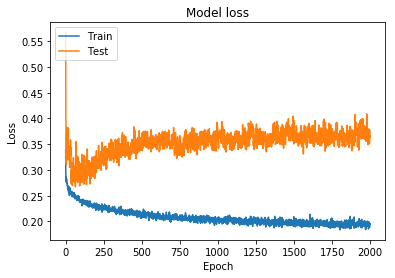

In [76]:
plt.figure()
plt.plot(multi_history.history['loss'])
plt.plot(multi_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Note!:** Definitely, the multistream ConvLSTM model overfits the data. However, my intention was not to tune optimally the model or to make it much deeper, but to show another more sophisticated Deep Learning approach for similar cases, since this method can be quite flexible and effective to complex Time-Series-related problems.